In [1]:
import pandas as pd
import numpy as np
import altair as alt
import glob
import os
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from scipy.signal import butter, filtfilt
import altair as alt
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal
import pywt
from scipy.stats import wilcoxon
import matplotlib.cm as cm


alt.data_transformers.disable_max_rows()
fs = 22050

In [2]:
metric_keys = ['mean','std']
submetric_keys = ['doub_freq_mag','SNR']

In [3]:
# Which fish?
subjid = 'hydrolagusColliei_8'

loaded = np.load(f'{subjid}_data.npz', allow_pickle=True)
data = loaded['data']
freq_amp_table = loaded['freq_amp_table']
latency = loaded['latency'].item()
channel_keys = loaded['channel_keys'].tolist()
period_keys = ['prestim','stimresp']
metric_keys = ['mean','variance','std']
data

array({(np.float64(55.0), np.float64(115.0)): {'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat', 'decision': array([[1.]]), 'period_len': 3528, 'ch1': array([[ 1.13919523,  0.29854812,  0.51171346, ...,  0.24535885,
         0.71333113,  0.17893058],
       [-0.53218433, -0.06263737,  0.94265154, ..., -0.704058  ,
         1.99663896,  3.66895166],
       [ 2.37567084,  1.16514833,  0.0586715 , ..., -1.92881097,
        -1.78592312, -0.78063422],
       ...,
       [ 0.52711035, -1.10291921, -1.87754631, ..., -0.50617291,
        -0.01370557, -0.80273809],
       [ 0.82851623,  0.15274419,  0.2325281 , ...,  1.65131694,
         1.86232438,  0.56490273],
       [ 2.03851384,  2.79068714,  2.93614113, ..., -1.96881957,
        -0.88677948, -1.29520543]], shape=(100, 10584)), 'ch2': array([[ 1.83689618,  1.50323847,  1.31520973, ..., -0.0951808 ,
        -0.09308123, -0.0600129 ],
       [-0.06205415,  0.44131932,  0.61360124, ...,  1.10729333,
         1.

In [4]:
freq_amp_table_df = pd.DataFrame(freq_amp_table).sort_values(by= [0,1],ascending=True)
print(list(data.item().keys()))
freq_amp_table_df

[(np.float64(55.0), np.float64(115.0)), (np.float64(55.0), np.float64(110.0)), (np.float64(55.0), np.float64(105.0)), (np.float64(55.0), np.float64(100.0)), (np.float64(55.0), np.float64(95.0)), (np.float64(220.0), np.float64(125.0)), (np.float64(220.0), np.float64(120.0)), (np.float64(220.0), np.float64(115.0)), (np.float64(220.0), np.float64(110.0)), (np.float64(220.0), np.float64(105.0)), (np.float64(220.0), np.float64(100.0)), (np.float64(220.0), np.float64(95.0)), (np.float64(220.0), np.float64(90.0)), (np.float64(880.0), np.float64(150.0)), (np.float64(880.0), np.float64(140.0)), (np.float64(100.0), np.float64(115.0)), (np.float64(100.0), np.float64(110.0)), (np.float64(100.0), np.float64(105.0)), (np.float64(100.0), np.float64(100.0)), (np.float64(440.0), np.float64(150.0)), (np.float64(1695.0), np.float64(150.0)), (np.float64(330.0), np.float64(150.0)), (np.float64(360.0), np.float64(150.0)), (np.float64(385.0), np.float64(150.0)), (np.float64(55.0), np.float64(90.0)), (np.floa

,0,1
30,55.0,90.0
4,55.0,95.0
29,55.0,95.0
3,55.0,100.0
28,55.0,100.0
2,55.0,105.0
27,55.0,105.0
1,55.0,110.0
26,55.0,110.0
0,55.0,115.0


### Artefact Rejection

In [14]:
def remove_artefacts(data):
    for coord, dictionary in data.item().items():
        for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
            rms_per_row = np.sqrt(np.mean(dictionary[channel]**2, axis=1))  # Get RMS of each row, axis = 1 means collapse rows
            rms_mean = np.mean(rms_per_row)
            rms_std = np.std(rms_per_row)
            
            # See which rows has an rms that is too high (i.e., artifact) and remove them
            threshold = rms_mean + (rms_std*3)
            keep_rows = rms_per_row <= threshold
            dictionary[channel] = dictionary[channel][keep_rows]
            dictionary[f'{channel}_total_trials'] = dictionary[channel].shape[0]
    
    for coord, dictionary in data.item().items():
        # Determine the minimum number of trials across all channels
        min_trials = min([dictionary[f'{channel}_total_trials'] for channel in ['ch1', 'ch2', 'ch3', 'ch4']])
        
        # Randomly select the same number of trials for each channel
        for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
            # Set a random seed for reproducibility if needed
            np.random.seed(42)
            
            # Get indices for the channel
            channel_indices = np.arange(dictionary[channel].shape[0])
            
            # Randomly select indices
            selected_indices = np.random.choice(channel_indices, size=min_trials, replace=False)
            
            # Update the channel data with selected trials
            dictionary[channel] = dictionary[channel][selected_indices]
            
            # Update the total trials count
            dictionary[f'{channel}_total_trials'] = min_trials
    
    return data

data = remove_artefacts(data)

In [15]:
data

array({(np.float64(55.0), np.float64(115.0)): {'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat', 'decision': array([[1.]]), 'period_len': 3528, 'ch1': array([[-2.69037403e+00, -1.45325689e+00, -1.94782380e+00, ...,
         4.05568199e-01, -2.11998908e-01, -1.21413845e+00],
       [ 1.50236365e-01, -2.93176701e+00,  1.41044885e+00, ...,
        -2.91607851e-04,  6.62183108e-01,  5.18128830e-01],
       [ 3.27434792e+00,  1.58418881e+00,  2.38966802e+00, ...,
        -8.92320025e-02, -3.27592260e-01, -5.94588408e-01],
       ...,
       [-8.48637168e-01, -2.05146123e+00, -1.87882938e+00, ...,
         2.94640573e-01,  7.16655455e-01,  8.45662768e-01],
       [-3.24676181e-01, -1.22708584e-01,  1.18217823e-01, ...,
         5.16729112e-02, -6.44569994e-01, -3.49346206e-02],
       [ 1.18666899e+00, -2.29262093e-01, -4.24406067e-01, ...,
         2.12377998e+00,  2.92663472e+00,  1.72491876e+00]],
      shape=(93, 10584)), 'ch2': array([[-1.61562414, -1.746

### Select stimulus

In [16]:
# Select which stimulus frequency and amplitude to analyze
myfreq = 100
myamp = 115
specific_key = (np.float64(myfreq), np.float64(myamp))
current_cond = data.item()[specific_key]
current_cond

{'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat',
 'decision': array([[1.]]),
 'period_len': 3528,
 'ch1': array([[ 1.4670791 ,  1.398143  , -0.27090369, ...,  0.71980482,
          1.53245758,  1.02406845],
        [ 1.35562658,  1.74859732,  0.79859726, ..., -0.04904844,
         -0.33657378,  0.26810426],
        [-0.21940575, -0.68988585, -0.37057526, ...,  0.01154767,
          0.78314205,  1.24481559],
        ...,
        [-2.23301628, -0.82775805,  0.29732337, ..., -0.04438271,
          1.26137892,  2.17265346],
        [ 1.96963607,  0.79259014,  0.57989137, ..., -0.93203701,
          0.27276998,  0.49835782],
        [ 0.20774143,  0.61126838,  0.08240838, ..., -0.78255883,
         -0.42236481, -0.52005344]], shape=(93, 10584)),
 'ch2': array([[ 1.28913999,  1.23029352,  1.39394385, ..., -0.28000186,
         -0.18120512, -0.15000308],
        [-1.41499794, -1.08618092, -0.66113332, ..., -0.00507398,
         -0.08001719, -0.23305299],
    

### Separate by periods

In [ ]:
def separate_periods(current_cond, period_keys, channel_keys, latency):
    data = {
        'prestim': {},
        'stimresp': {}
    }
    
    period_len = current_cond['period_len']
    
    for period in period_keys:
        for channel in channel_keys:            
            if period == 'prestim':
                data[period][channel] = current_cond[channel][:,latency:latency+period_len]
                
            elif period == 'stimresp':
                data[period][channel] = current_cond[channel][:,latency+period_len:latency+period_len*2]
                
    return data

data = separate_periods(current_cond, period_keys, channel_keys, latency)
### Did I select the correct periods?
# yes 11/6/2025

### Calculate welch's fft

In [ ]:
def compute_welch_fft(data, period_keys, channel_keys, fs):
    from scipy.signal import welch
    freq_step = 1
    pow_two = np.ceil(np.log2(fs/freq_step)) # Compute base 2 logarithm, i.e., what number i need to raise 2 by to get this value. But i wan a whole number so i ceil it
    n_fft = int(2**pow_two) # Nearest power of two for computational efficiency that gives me freq_step of 1
    
    fft_data = {
        'prestim': {},
        'stimresp': {}
    }
        
    for period in period_keys:
        for channel in channel_keys:
            fft_data[period][channel] = {}
            cur_chan = data[period][channel]
            trial_magnitudes = []
            for i_trial in range(cur_chan.shape[0]):
                cur_trial = cur_chan[i_trial]
                n_samples = len(cur_trial) # Here we will want to describe the size of windows to segment and average. If nperseg = n, then
                
                f, Pxx = welch(cur_trial, fs=fs, nperseg=n_samples, nfft=n_fft, scaling='spectrum')
                
                if period == 'prestim' and channel == 'ch1' and i_trial == 1:
                    freq_vec = f
                
                magnitude = np.sqrt(Pxx)
                trial_magnitudes.append(magnitude)
                
            fft_data[period][channel] = np.vstack(trial_magnitudes)
                
    return fft_data, freq_vec

fft_data, freq_vec = compute_welch_fft(data, period_keys, channel_keys,fs)

In [ ]:
len(fft_data['stimresp']['ch1'])

97

### Plot raw ffts from random trials

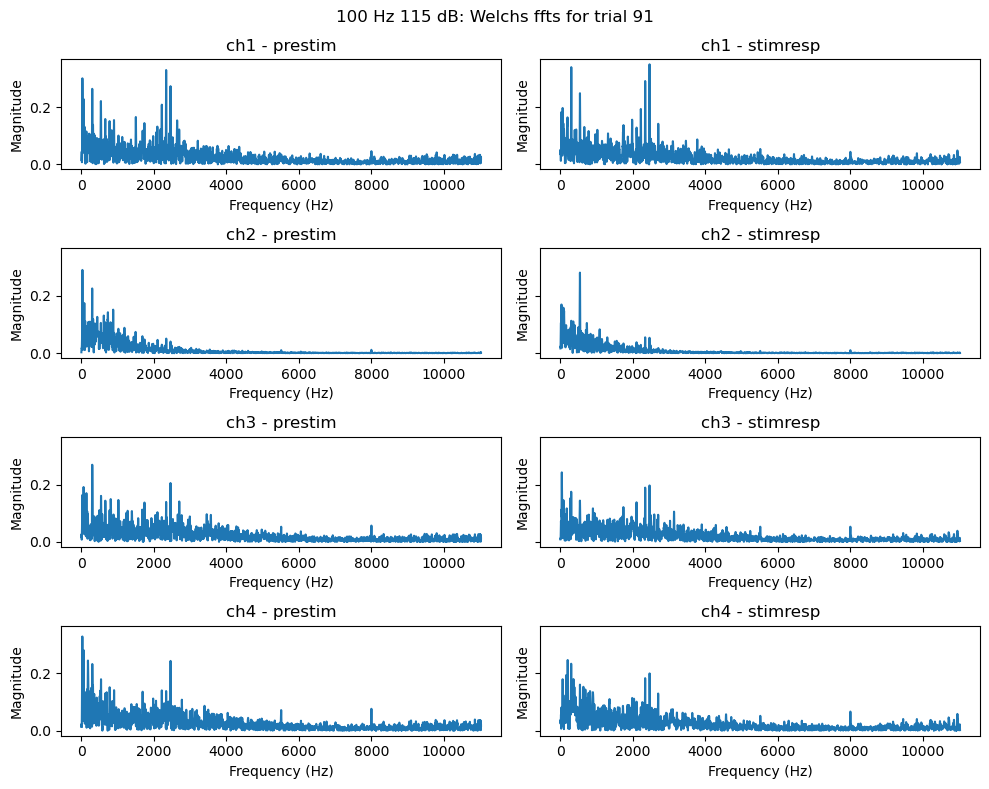

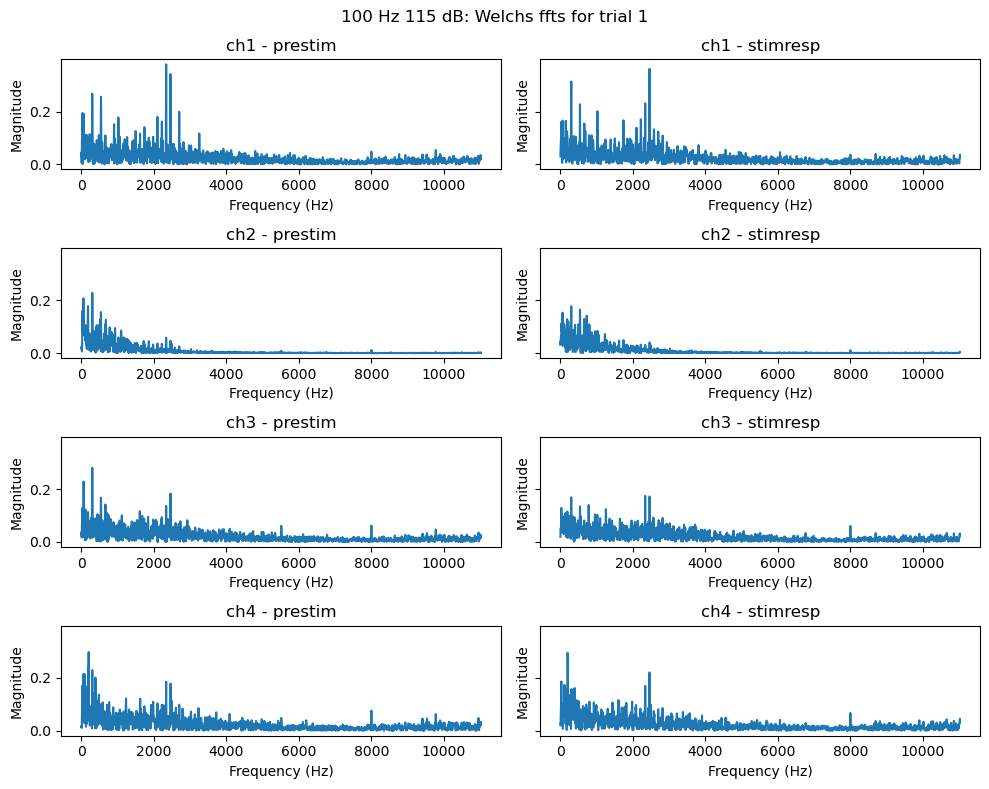

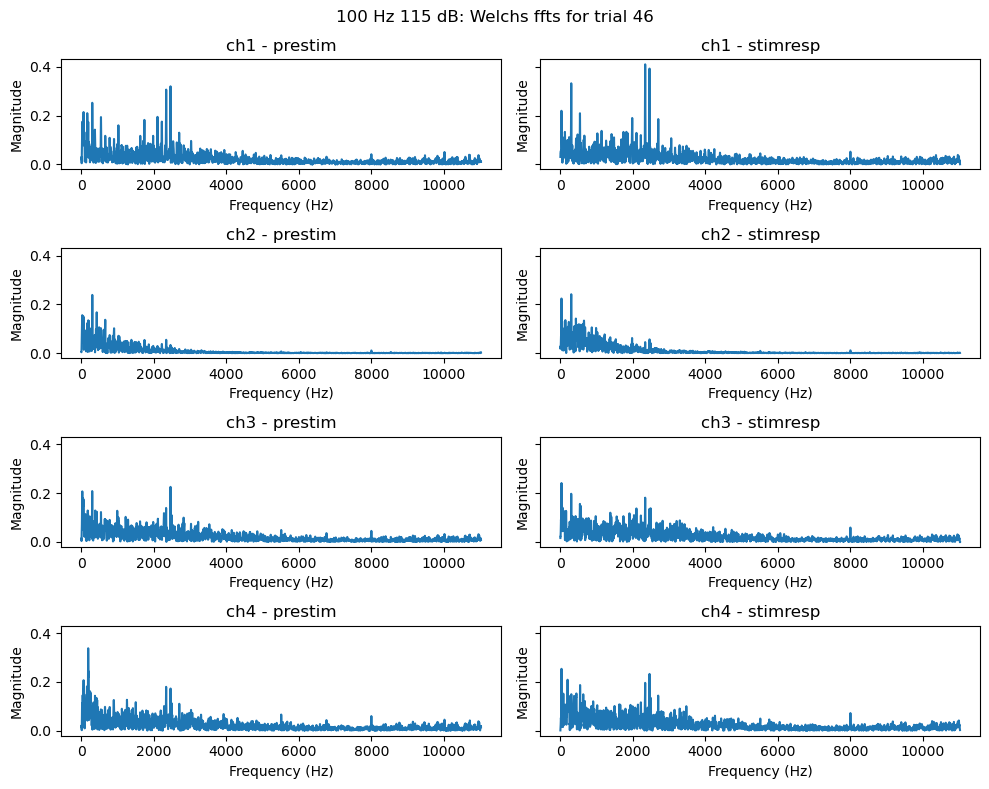

In [ ]:
def plot_ffts(fft_data, period_keys, channel_keys, subjid, freq_vec, myfreq, myamp):
    import random
    import matplotlib.pyplot as plt
    
    total_trials = len(fft_data['stimresp']['ch1'])
    random_trials = random.sample(range(total_trials), 3)
    
    for random_trial in random_trials:
        # Create a new figure for each trial
        fig, axs = plt.subplots(len(channel_keys), len(period_keys), figsize=(10, 8), sharey=True)
        
        for i, channel in enumerate(channel_keys):
            for j, period in enumerate(period_keys):
                axs[i, j].plot(freq_vec, fft_data[period][channel][random_trial])
                axs[i, j].set_title(f'{channel} - {period}')
                axs[i, j].set_xlabel('Frequency (Hz)')
                axs[i, j].set_ylabel('Magnitude')
        
        plt.suptitle(f'{myfreq} Hz {myamp} dB: Welchs ffts for trial {random_trial}')
        plt.tight_layout()
        plt.savefig(f"{subjid}_rand_cum_avg_fft_trial_{random_trial}_{myfreq}Hz_{myamp}dB.png", 
                    format='png', 
                    bbox_inches='tight', 
                    dpi=300)
        plt.show(fig)  # Close the figure after saving

### Conduct bootstrapping

In [ ]:
def create_bootstrap_distribution(fft_data, period_keys, channel_keys, fs, 
                                  n_samples=1000, 
                                  sample_fraction=0.75, 
                                  random_seed=None):
    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    bootstrap_data = {
        'prestim': {},
        'stimresp': {}
    }
    
    for period in period_keys:
        for channel in channel_keys:
            # Initialize bootstrap statistics storage
            bootstrap_data[period][channel] = {
                'mean': [],
                'variance': [],
                'std': []
            }
            
            data_array = fft_data[period][channel]
            total_samples = len(data_array)
            
            # Calculate exact number of samples to use
            sample_size = int(total_samples * sample_fraction)
            
            # Perform bootstrap sampling
            bootstrap_means = []
            bootstrap_variances = []
            bootstrap_stds = []
            
            for _ in range(n_samples):
                # Ensure consistent sampling size
                bootstrap_indices = np.random.choice(
                    total_samples, 
                    size=sample_size, 
                    replace=True
                )
                bootstrap_sample = data_array[bootstrap_indices]
                
                # Compute statistics for this bootstrap sample
                bootstrap_means.append(np.mean(bootstrap_sample, axis=0))
                bootstrap_variances.append(np.var(bootstrap_sample, axis=0))
                bootstrap_stds.append(np.std(bootstrap_sample, axis=0))
            
            # Convert to NumPy arrays for easier manipulation
            bootstrap_data[period][channel]['mean'] = np.array(bootstrap_means)
            bootstrap_data[period][channel]['variance'] = np.array(bootstrap_variances)
            bootstrap_data[period][channel]['std'] = np.array(bootstrap_stds)
    
    return bootstrap_data

In [ ]:
bootstrap_data = create_bootstrap_distribution(fft_data, period_keys, channel_keys, fs
,sample_fraction=0.75, random_seed=1)

In [ ]:
fft_data

{'prestim': {'ch1': array([[0.06103276, 0.08605931, 0.08532053, ..., 0.01118026, 0.01084596,
          0.00759878],
         [0.03260154, 0.04567615, 0.04439078, ..., 0.03076868, 0.03154761,
          0.0224944 ],
         [0.00551582, 0.00811922, 0.00923706, ..., 0.01469958, 0.01432804,
          0.01004064],
         ...,
         [0.01687454, 0.0251982 , 0.0287889 , ..., 0.00351543, 0.00305075,
          0.00203142],
         [0.01636394, 0.02314567, 0.02316911, ..., 0.00600186, 0.00348547,
          0.00130798],
         [0.03239101, 0.04621169, 0.04741106, ..., 0.01649915, 0.01705896,
          0.0121965 ]], shape=(97, 16385)),
  'ch2': array([[0.04525612, 0.06373891, 0.06298268, ..., 0.00423287, 0.00435715,
          0.00311063],
         [0.01553752, 0.02193225, 0.02180992, ..., 0.00316083, 0.00323553,
          0.00230573],
         [0.00448545, 0.00636731, 0.0066595 , ..., 0.00296603, 0.0030164 ,
          0.00214497],
         ...,
         [0.01510508, 0.02269845, 0.02629969

In [ ]:
bootstrap_data

{'prestim': {'ch1': {'mean_distribution': [],
   'variance_distribution': [],
   'std_distribution': [],
   'mean': array([[0.02185543, 0.03125028, 0.03172014, ..., 0.01510134, 0.01496745,
           0.0105191 ],
          [0.02021305, 0.02875881, 0.02907247, ..., 0.01730524, 0.01713817,
           0.01206107],
          [0.02296138, 0.03285083, 0.03350552, ..., 0.01652789, 0.01637016,
           0.01151865],
          ...,
          [0.01900104, 0.02744692, 0.02832524, ..., 0.01856687, 0.01855486,
           0.0130989 ],
          [0.02319738, 0.03300449, 0.033359  , ..., 0.01836227, 0.01825713,
           0.01285857],
          [0.02583766, 0.03670399, 0.03699555, ..., 0.01881935, 0.01867693,
           0.01314989]], shape=(1000, 16385)),
   'variance': array([[2.65848369e-04, 5.05435236e-04, 4.62246539e-04, ...,
           1.19012586e-04, 1.27775303e-04, 6.60721158e-05],
          [1.91054547e-04, 3.68701009e-04, 3.41564340e-04, ...,
           1.53376268e-04, 1.63140555e-04, 8.3642

### Conduct cumulative averaging (defunct)

In [ ]:
def compute_cumulative_avg(fft_data, period_keys, channel_keys, fs, keep_last):
### Hmm still need to learn about computationally efficient variance calculations
    cumu_data = {
        'prestim': {},
        'stimresp': {}
    }
    
    for period in period_keys:
        for channel in channel_keys:
            cumu_data[period][channel] = {
                'mean': [],
                'variance': [],
                'std': []
            }

            data_array = fft_data[period][channel]         
            trial_count_vector = np.arange(1, len(data_array) + 1)
            
            cumu_mean = np.cumsum(data_array, axis=0) / np.arange(1, len(data_array) + 1)[:, np.newaxis]
            cumu_variance = (np.cumsum(data_array**2, axis=0) / np.arange(1, len(data_array) + 1)[:, np.newaxis]) - (cumu_mean**2)
            cumu_std = np.sqrt(cumu_variance)
            
            cumu_data[period][channel]['mean'] = cumu_mean[-keep_last:]
            cumu_data[period][channel]['variance'] = cumu_variance[-keep_last:]
            cumu_data[period][channel]['std'] = cumu_std[-keep_last:]
    
    return cumu_data, trial_count_vector

### Plot FFTs

In [ ]:
def plot_cumulative_ffts(data, period_keys, channel_keys, subjid, freq_vec, myfreq, myamp, x_min=None, x_max=None):
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, axs = plt.subplots(len(channel_keys), len(period_keys), figsize=(10, 8), sharey=True)
    
    for i, channel in enumerate(channel_keys):
        for j, period in enumerate(period_keys):
            # Get the cumulative mean and standard deviation
            mean = data[period][channel]['mean'][-1]  # Last cumulative mean
            std = data[period][channel]['std'][-1]    # Last cumulative standard deviation
            
            # Plot the mean
            axs[i, j].plot(freq_vec, mean, label='Mean')
            
            # Add shaded area for +1 standard deviation
            axs[i, j].fill_between(freq_vec, 
                                   mean, 
                                   mean + std, 
                                   alpha=0.3, 
                                   label='+1 Std Dev')
            
            axs[i, j].set_title(f'{channel} - {period}')
            axs[i, j].set_xlabel('Frequency (Hz)')
            axs[i, j].set_ylabel('Magnitude')
            axs[i, j].legend()
            
            # Set x-axis limits if provided
            if x_min is not None and x_max is not None:
                axs[i, j].set_xlim(x_min, x_max)
    
    plt.suptitle(f'{myfreq} Hz {myamp} dB: Cumulative Average FFTs')
    plt.tight_layout()
    
    plt.savefig(f"{subjid}_last_cum_avg_fft_{myfreq}Hz_{myamp}dB.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=300)
    
    plt.show()


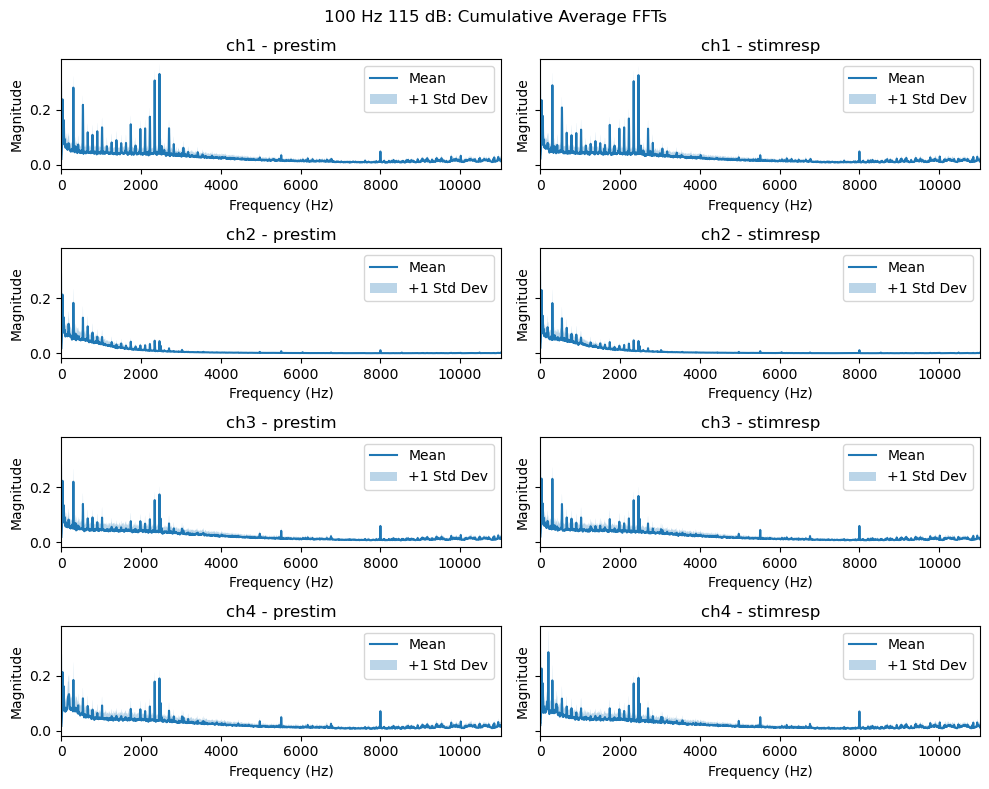

In [ ]:
plot_cumulative_ffts(bootstrap_data, period_keys, channel_keys, subjid, freq_vec, myfreq, myamp, x_min=0, x_max=11025)

### Select the double frequency response

In [ ]:
def select_doub_freq_bin(data, freq_vec, period_keys, channel_keys, metric_keys, myfreq):
    # Select double frequency bin
    target_freq = 2*myfreq
    
    # Initialize nested dictionary with correct structure
    doub_freq_data = {
        'prestim': {channel: {metric: {} for metric in metric_keys} for channel in channel_keys},
        'stimresp': {channel: {metric: {} for metric in metric_keys} for channel in channel_keys}
    }
    
    artifact_freqs = [myfreq, 60, 120, 180, 240, 300, 360, 420, 480, 540]
    
    for period in period_keys:
        for channel in channel_keys:
            cur_loc = bootstrap_data[period][channel]['mean']
            doub_freq_mag_tmp = []
            remain_mag_tmp = []
            for i_trial in range(0,len(cur_loc)):
                cur_trial = cur_loc[i_trial]
                freq_index = np.argmin(np.abs(freq_vec-target_freq))
                
                doub_mask = np.zeros_like(freq_vec, dtype=bool)
                doub_mask[freq_index] = True
                doub_mag = cur_trial[doub_mask]
                
                doub_freq_mag_tmp.append(doub_mag)
                
                remain_mask = np.ones_like(freq_vec, dtype=bool)
                remain_mask[freq_index] = False
                    
                for freq in artifact_freqs:
                    art_index = np.argmin(np.abs(freq_vec - freq))
                    remain_mask[art_index] = False
                        
                remain_mag = np.std(cur_trial[remain_mask])
                remain_mag_tmp.append(10 * np.log10((doub_mag) / (remain_mag**2)))
                
            doub_freq_data[period][channel]['mean']['doub_freq_mag'] = np.hstack(doub_freq_mag_tmp)
            doub_freq_data[period][channel]['mean']['SNR'] = np.hstack(remain_mag_tmp)
                
    return doub_freq_data


In [ ]:
metric_keys = ['mean']
doub_freq_data = select_doub_freq_bin(bootstrap_data, freq_vec, period_keys, channel_keys, metric_keys, myfreq)

In [297]:
doub_freq_data

{'prestim': {'ch1': {'mean': {'doub_freq_mag': array([0.06692286, 0.05943217, 0.06470964, 0.06060701, 0.06060673,
           0.06211335, 0.06335145, 0.05626426, 0.06553039, 0.06364702,
           0.06375234, 0.05466256, 0.05266945, 0.05744089, 0.06006593,
           0.0544732 , 0.05598905, 0.06619213, 0.06219063, 0.05980501,
           0.0555778 , 0.06202871, 0.05564603, 0.05832526, 0.05864747,
           0.059322  , 0.05761788, 0.05893089, 0.06126663, 0.06550458,
           0.05661607, 0.0582365 , 0.05944754, 0.05626036, 0.05857679,
           0.06317481, 0.05479224, 0.05930769, 0.06535125, 0.05546474,
           0.06121037, 0.06120504, 0.06402032, 0.06142945, 0.06512902,
           0.06009494, 0.05772666, 0.0582695 , 0.0630039 , 0.05656471,
           0.05993283, 0.0586236 , 0.05840182, 0.06584367, 0.05367575,
           0.05643928, 0.05671321, 0.05889747, 0.06551848, 0.05859331,
           0.05939492, 0.05876555, 0.05400679, 0.05612737, 0.06393896,
           0.0551586 , 0.06624039,

### Check to see if std value is completely nuts and remove channels that have it

In [298]:
def find_large_stds(doub_freq_data, period_keys, channel_keys, metric_keys):
    my_rat_data = {}
    for channel in channel_keys.copy():
        my_rat_data[channel] = []
        my_mean = doub_freq_data['stimresp'][channel]['mean']['doub_freq_mag'][-1] # select the last cumulative trial
        my_std = doub_freq_data['stimresp'][channel]['std']['doub_freq_mag'][-1]
        my_rat = my_std/my_mean
        my_rat_data[channel].append(my_rat)
        
        print(f"{channel} : {my_rat}")
    
        if my_rat > 6:
            print(f"Warning {channel} has super high std value")
            
    filt_channel_keys = channel_keys

    return my_rat_data, filt_channel_keys


In [299]:
my_rat_data, filt_channel_keys = find_large_stds(doub_freq_data, period_keys, channel_keys, metric_keys)    

KeyError: 'std'

### Power analysis: Figure out how many of the last trials to use

In [251]:
# Write later

In [252]:
len(doub_freq_data['prestim']['ch1']['mean']['SNR'])


97

### Won't collapse anymore

In [253]:
def collapse_the_data(data, period_keys, filt_channel_keys, use_last = 50):
# range(1,len(pre_stim_fft['ch1'])) since the first entry has only one trial in the average, so no variance!
    first_chan = filt_channel_keys[0]
    sub_metric_keys = ['doub_freq_mag', 'doub_freq_mag_std','SNR']
    total_avgs = len(data['prestim']['ch1']['mean']['SNR'])

    collapsed_data = {}
    for period in period_keys:
        collapsed_data[period] = {
            'doub_freq_mag': [],
            'doub_freq_mag_std': [],
            'SNR': []
        }

    for period in period_keys:
        for sub_metric in sub_metric_keys:
            if sub_metric == 'doub_freq_mag':
                collapsed_data[period][sub_metric] = np.concatenate([
                    data[period][channel]['mean']['doub_freq_mag'][total_avgs-use_last:total_avgs]
                    for channel in filt_channel_keys
                ])
                
            elif sub_metric == 'doub_freq_mag_std':
                collapsed_data[period][sub_metric] = np.concatenate([
                    data[period][channel]['std']['doub_freq_mag'][total_avgs-use_last:total_avgs]
                    for channel in filt_channel_keys
                ])
                
            elif sub_metric == 'SNR':
                collapsed_data[period][sub_metric] = np.concatenate([
                    data[period][channel]['mean']['SNR'][total_avgs-use_last:total_avgs]
                    for channel in filt_channel_keys
                ])

    return collapsed_data

collapsed_data = collapse_the_data(doub_freq_data, period_keys, filt_channel_keys, use_last = 50)
# len(collapsed_data['prestim']['SNR']) == 4 x use_last


### Histogram code

In [254]:
def plot_hist(data, subjid, channel_keys, submetric_keys, myfreq, myamp, bin_num):
    for submetric in submetric_keys:
        # Create the figure for each submetric
        fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True, sharey=True)
        
        # Iterate through channels
        for i, channel in enumerate(channel_keys):
            # Prestim (Stim OFF) histogram
            axes[i, 0].hist(data['prestim'][channel]['mean'][submetric], 
                            bins=bin_num, edgecolor='black')
            axes[i, 0].set_title(f'{channel} Stim OFF - {submetric}')
            axes[i, 0].set_xlabel('Power')
            axes[i, 0].set_ylabel('Frequency')
            axes[i, 0].set_yscale('log')
            
            # Stimresp (Stim ON) histogram
            axes[i, 1].hist(data['stimresp'][channel]['mean'][submetric], 
                            bins=bin_num, edgecolor='black')
            axes[i, 1].set_title(f'{channel} Stim ON - {submetric}')
            axes[i, 1].set_xlabel('Power')
            axes[i, 1].set_ylabel('Frequency')
            axes[i, 1].set_yscale('log')
        
        # Overall figure title
        fig.suptitle(f"{subjid} 2x Freq. Resp. {submetric} Comparison {myfreq}Hz {myamp}dB", 
                    fontsize=16)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save figure
        plt.savefig(f"{subjid}_2x_resp_hist_{submetric}_{myfreq}Hz_{myamp}dB.png", 
                    format='png', 
                    bbox_inches='tight', 
                    dpi=300)
        
        # Show the plot and keep it open
        plt.show()

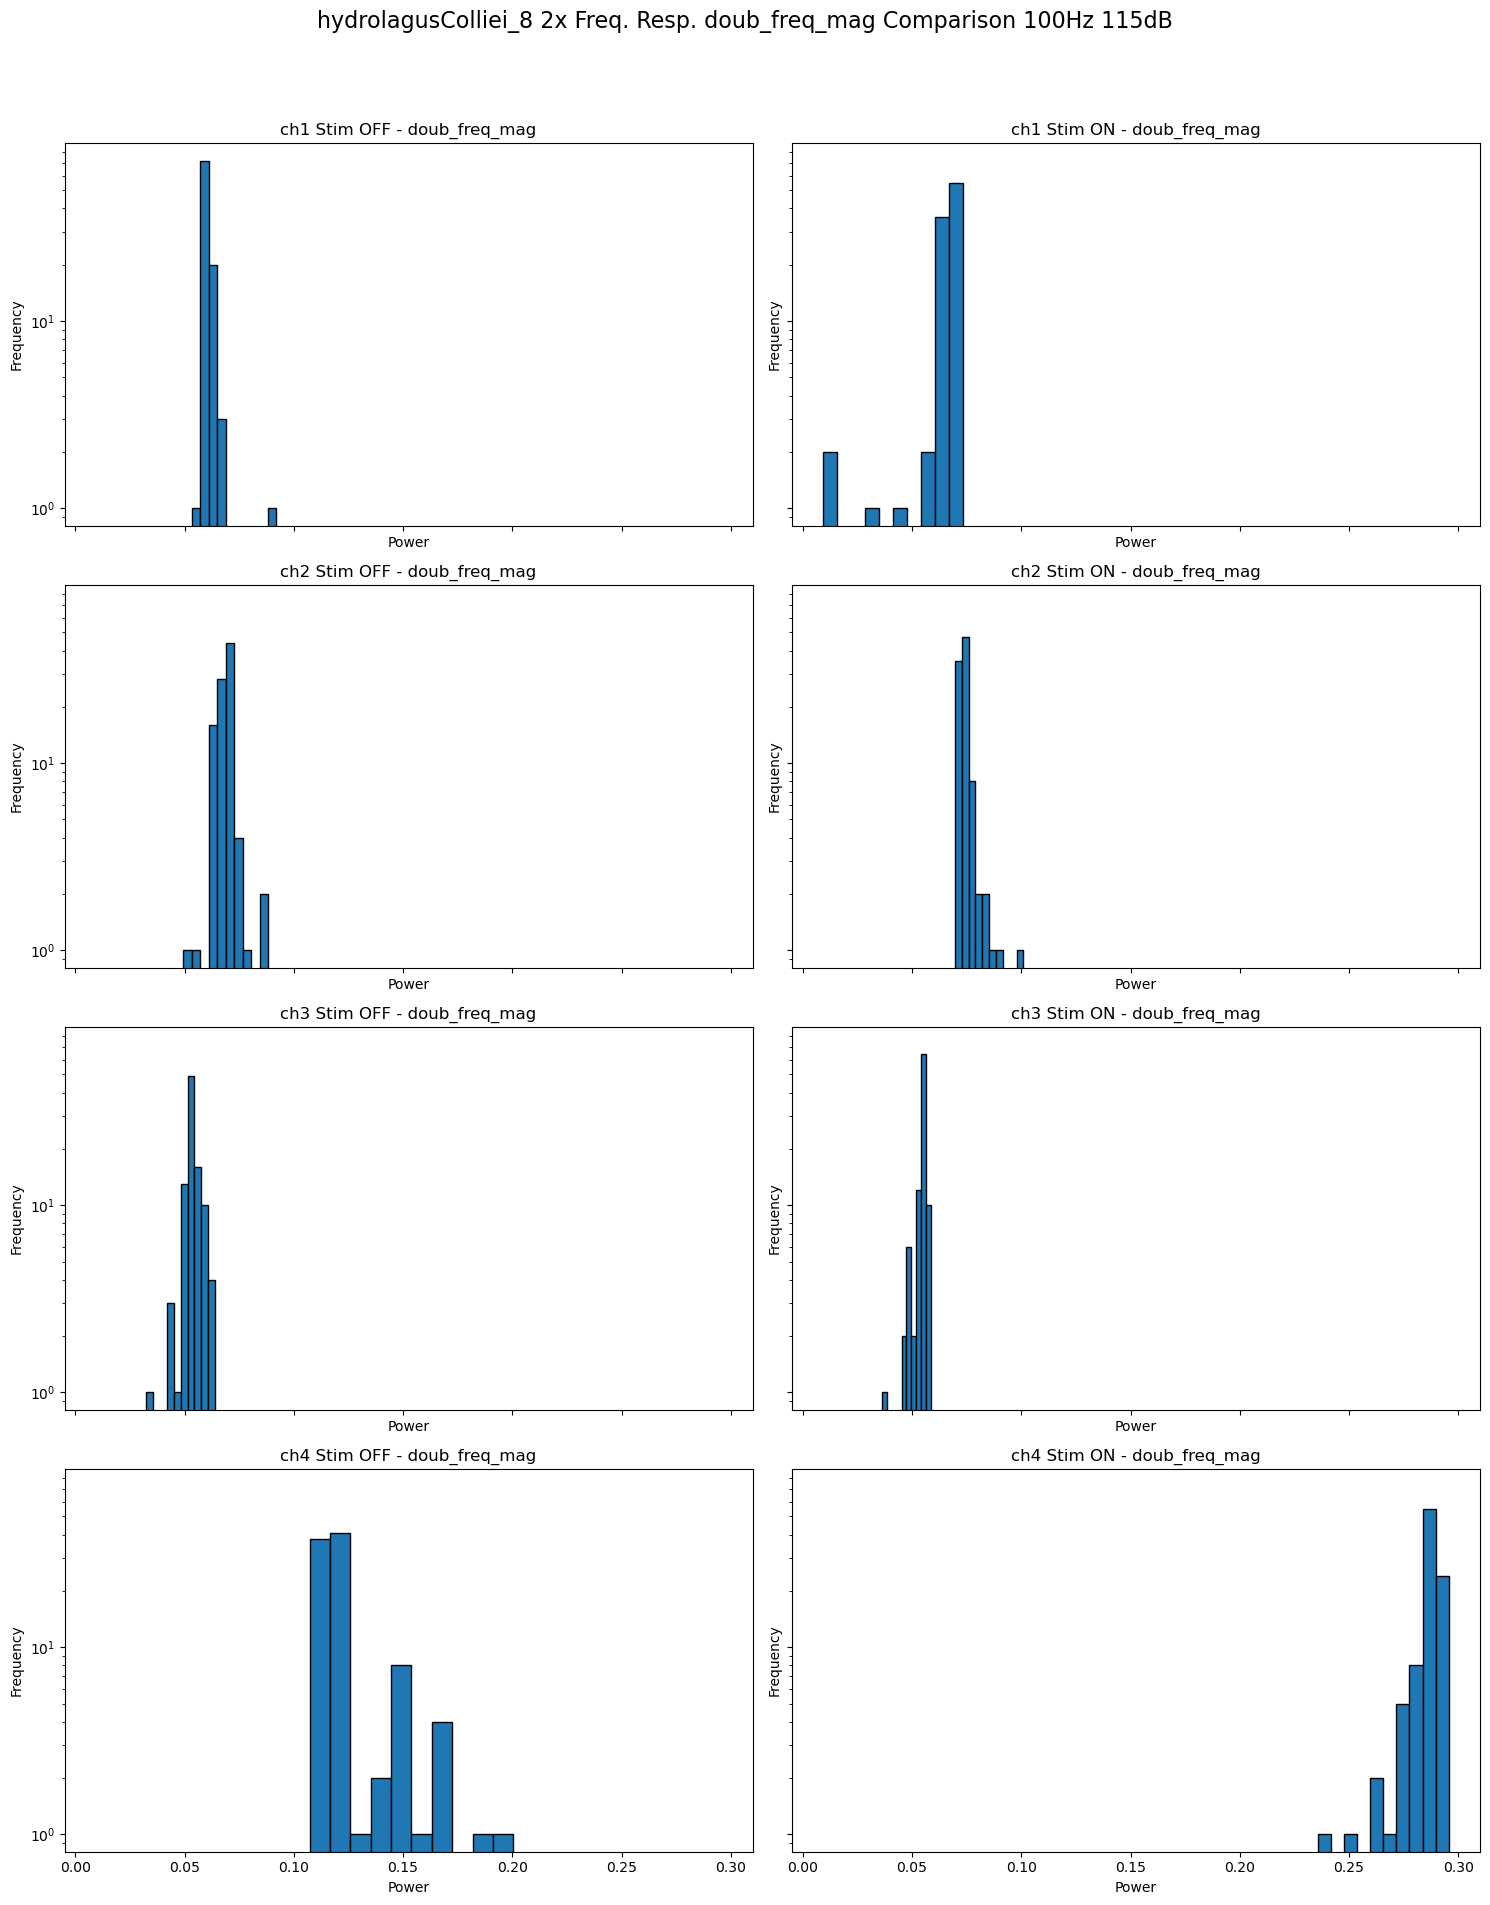

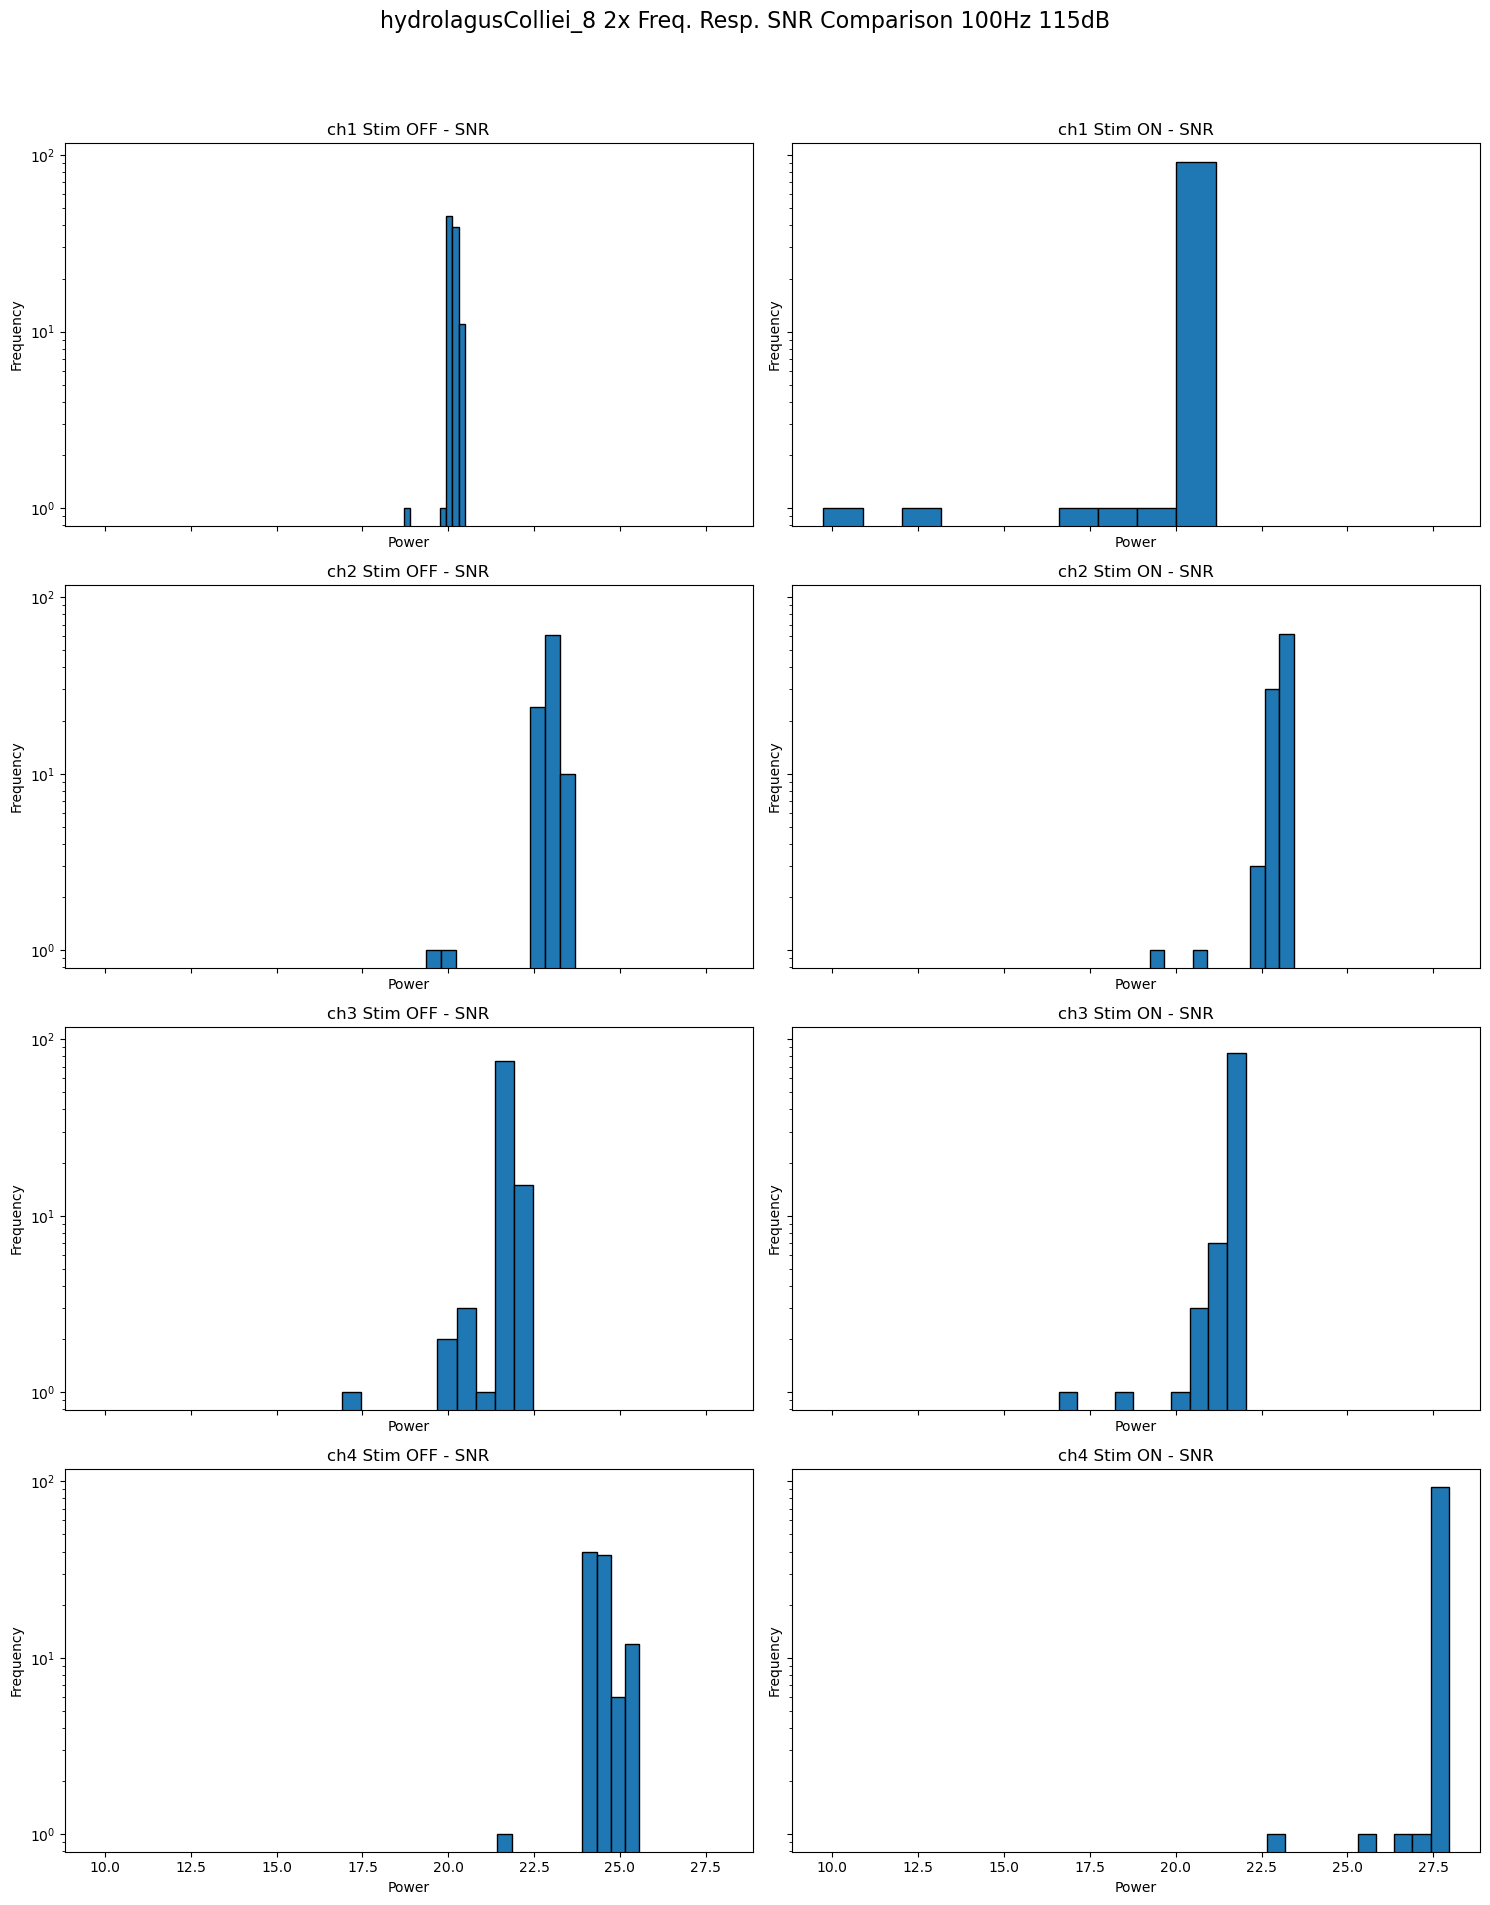

In [255]:
plot_hist(doub_freq_data, subjid, channel_keys, submetric_keys, myfreq, myamp,10)

### Wilcoxon

In [256]:
def calc_wilcoxon(data, channel_keys, metric):
    results = {}
    for channel in channel_keys:
        prestim = data['prestim'][channel]['mean'][metric]
        stimresp = data['stimresp'][channel]['mean'][metric]
        stat, p_value = wilcoxon(prestim, stimresp)
        
        # Calculate paired differences
        differences = stimresp - prestim
        mean_difference = np.mean(differences)  # negative means prestim is larger
        
        print(f'Wilcoxon for Channel {channel} and metric {metric}')
        print('Statistic:', stat)
        print('P-value:', p_value)
        
        results[channel] = {
            'statistic': stat,
            'p_value': p_value,
            'mean_difference': mean_difference
        }
    
    return results

In [257]:
wilcox_doub_freq_mag = calc_wilcoxon(doub_freq_data, channel_keys, 'doub_freq_mag')
wilcox_SNR = calc_wilcoxon(doub_freq_data, channel_keys, 'SNR')

Wilcoxon for Channel ch1 and metric doub_freq_mag
Statistic: 409.0
P-value: 1.4464886814901418e-12
Wilcoxon for Channel ch2 and metric doub_freq_mag
Statistic: 0.0
P-value: 1.218119098708288e-17
Wilcoxon for Channel ch3 and metric doub_freq_mag
Statistic: 1583.0
P-value: 0.0043009907340463005
Wilcoxon for Channel ch4 and metric doub_freq_mag
Statistic: 0.0
P-value: 1.218119098708288e-17
Wilcoxon for Channel ch1 and metric SNR
Statistic: 385.0
P-value: 7.72866864926471e-13
Wilcoxon for Channel ch2 and metric SNR
Statistic: 1352.0
P-value: 0.00022745698103720488
Wilcoxon for Channel ch3 and metric SNR
Statistic: 1989.0
P-value: 0.1632222924517398
Wilcoxon for Channel ch4 and metric SNR
Statistic: 0.0
P-value: 1.218119098708288e-17


In [258]:
wilcox_SNR

{'ch1': {'statistic': np.float64(385.0),
  'p_value': np.float64(7.72866864926471e-13),
  'mean_difference': np.float64(0.34819882098926325)},
 'ch2': {'statistic': np.float64(1352.0),
  'p_value': np.float64(0.00022745698103720488),
  'mean_difference': np.float64(0.07555653555069392)},
 'ch3': {'statistic': np.float64(1989.0),
  'p_value': np.float64(0.1632222924517398),
  'mean_difference': np.float64(-0.01784679692545725)},
 'ch4': {'statistic': np.float64(0.0),
  'p_value': np.float64(1.218119098708288e-17),
  'mean_difference': np.float64(3.2875295430803795)}}

### Permutation test

In [259]:
import numpy as np
from scipy import stats

def calc_paired_perm(data, channel_keys, metric, n_resamples):
    # Validate input
    if 'prestim' not in data or 'stimresp' not in data:
        raise ValueError("Data must contain 'prestim' and 'stimresp' keys")
    
    results = {}
    
    for channel in channel_keys:
        # Extract data for the specific metric and channel
        prestim = data['prestim'][channel]['mean'][metric]
        stimresp = data['stimresp'][channel]['mean'][metric]
        
        # Perform permutation test
        def statistic(x, y):
            return np.median(x) - np.median(y)
        
        result = stats.permutation_test(
            (prestim, stimresp), 
            statistic, 
            n_resamples=n_resamples,  # Use the input parameter
            vectorized=False,
            alternative='two-sided'
        )
        
        # Store results for each channel
        results[channel] = {
            'statistic': result.statistic,  # Observed difference in means
            'p_value': result.pvalue,       # P-value from the test
            'null_distribution': result.null_distribution  # Distribution of permuted differences
        }
    
    return results

In [260]:
perm_doub_freq_mag = calc_paired_perm(doub_freq_data, channel_keys, 'doub_freq_mag', n_resamples=10000)
perm_SNR = calc_paired_perm(doub_freq_data, channel_keys, 'SNR', n_resamples=10000)

In [261]:
perm_doub_freq_mag

{'ch1': {'statistic': np.float64(-0.00803453637806105),
  'p_value': np.float64(0.00019998000199980003),
  'null_distribution': array([ 7.07631923e-05, -9.43199661e-04, -6.91653875e-04, ...,
          8.61605542e-04, -1.43333214e-03, -4.29062919e-04], shape=(10000,))},
 'ch2': {'statistic': np.float64(-0.004061408350065784),
  'p_value': np.float64(0.00019998000199980003),
  'null_distribution': array([-0.00048894, -0.0010976 , -0.00155298, ..., -0.00060987,
         -0.00192126,  0.0003218 ], shape=(10000,))},
 'ch3': {'statistic': np.float64(-0.0021785551637900497),
  'p_value': np.float64(0.00019998000199980003),
  'null_distribution': array([ 0.00012887, -0.00023988,  0.00011565, ..., -0.00045529,
         -0.00019769,  0.00023884], shape=(10000,))},
 'ch4': {'statistic': np.float64(-0.17001227257364437),
  'p_value': np.float64(0.00019998000199980003),
  'null_distribution': array([ 0.07971675, -0.11737101, -0.09485125, ..., -0.12512217,
         -0.09485125,  0.13385958], shape=(

## Check if wilcoxon is reasonable (i.e., sign reversal based)
Wilcoxon ranks the absolute values of stimresp - prestim within each pair.
It then sums the ranks of positive and negative differences.

If all your differences have the same sign (e.g., every stimresp > prestim), then:

All signed ranks go in one direction.

The Wilcoxon statistic = 0 (or N(N+1)/2 for the other side, depending on implementation).

The p-value will be extremely small (like 1.4e-34), indicating a systematic shift.

So even if one metric has an average change of +0.02 and the other +1.30,
if all the paired differences are positive in both, you’ll get the same statistic and p-value.

In [262]:
diff1 = collapsed_data['stimresp']['doub_freq_mag'] - collapsed_data['prestim']['doub_freq_mag']
diff2 = collapsed_data['stimresp']['SNR'] - collapsed_data['prestim']['SNR']

np.sign(diff1)
np.sign(diff2)


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

## Colored histogram by average trial num

In [263]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def color_hist_bars(ax, data, num_bins, vmin=None, vmax=None):
    # Compute histogram and bin edges
    counts, edges = np.histogram(data, bins=num_bins)
    
    # Initialize an array to store average values for each bin
    bin_averages = np.zeros_like(counts, dtype=float)
    
    # Calculate average value for each bin
    for i in range(len(edges) - 1):
        # Find trials falling in this bin
        bin_mask = (data >= edges[i]) & (data < edges[i+1])
        
        # If no trials in this bin, average remains 0
        if np.sum(bin_mask) > 0:
            bin_averages[i] = np.mean(data[bin_mask])
    
    # If vmin and vmax are not provided, use the min and max of this data
    if vmin is None:
        vmin = bin_averages.min()
    if vmax is None:
        vmax = bin_averages.max()
    
    # Create color map
    norm = plt.Normalize(vmin, vmax)
    colors = cm.viridis(norm(bin_averages))
    
    # Plot histogram with color-coded bars
    ax.bar(edges[:-1], counts, width=np.diff(edges), align='edge', 
        color=colors, edgecolor='black', linewidth=1, alpha=0.7)
    
    # Add colorbar
    sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Average Value')
    
    return vmin, vmax

def plot_collapsed_color_hist(data, subjid, channel_keys, submetric_keys, myfreq, myamp, num_bins):
    for submetric in submetric_keys:
        # Create the figure for each submetric
        fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True, sharey=True)
        
        # Find global min and max for consistent color scaling
        all_prestim = np.concatenate([data['prestim'][channel]['mean'][submetric] for channel in channel_keys])
        all_stimresp = np.concatenate([data['stimresp'][channel]['mean'][submetric] for channel in channel_keys])
        global_min = min(np.min(all_prestim), np.min(all_stimresp))
        global_max = max(np.max(all_prestim), np.max(all_stimresp))
        
        # Iterate through channels
        for i, channel in enumerate(channel_keys):
            # Prestim (Stim OFF) histogram
            vmin, vmax = color_hist_bars(axes[i, 0], 
                                         data['prestim'][channel]['mean'][submetric], 
                                         num_bins,
                                         vmin=global_min, 
                                         vmax=global_max)
            axes[i, 0].set_title(f'{channel} Stim OFF - {submetric}')
            axes[i, 0].set_xlabel('Power')
            axes[i, 0].set_ylabel('Frequency')
            axes[i, 0].set_yscale('log')
            
            # Stimresp (Stim ON) histogram
            color_hist_bars(axes[i, 1], 
                            data['stimresp'][channel]['mean'][submetric],
                            num_bins, 
                            vmin=vmin, 
                            vmax=vmax)
            axes[i, 1].set_title(f'{channel} Stim ON - {submetric}')
            axes[i, 1].set_xlabel('Power')
            axes[i, 1].set_ylabel('Frequency')
            axes[i, 1].set_yscale('log')
        
        # Overall figure title
        fig.suptitle(f"{subjid} 2x Freq. Resp. {submetric} Comparison {myfreq}Hz {myamp}dB", 
                    fontsize=16)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save figure
        plt.savefig(f"{subjid}_2x_resp_color_hist_{submetric}_{myfreq}Hz_{myamp}dB.png", 
                    format='png', 
                    bbox_inches='tight', 
                    dpi=300)
        
        # Show the plot 
        plt.show()

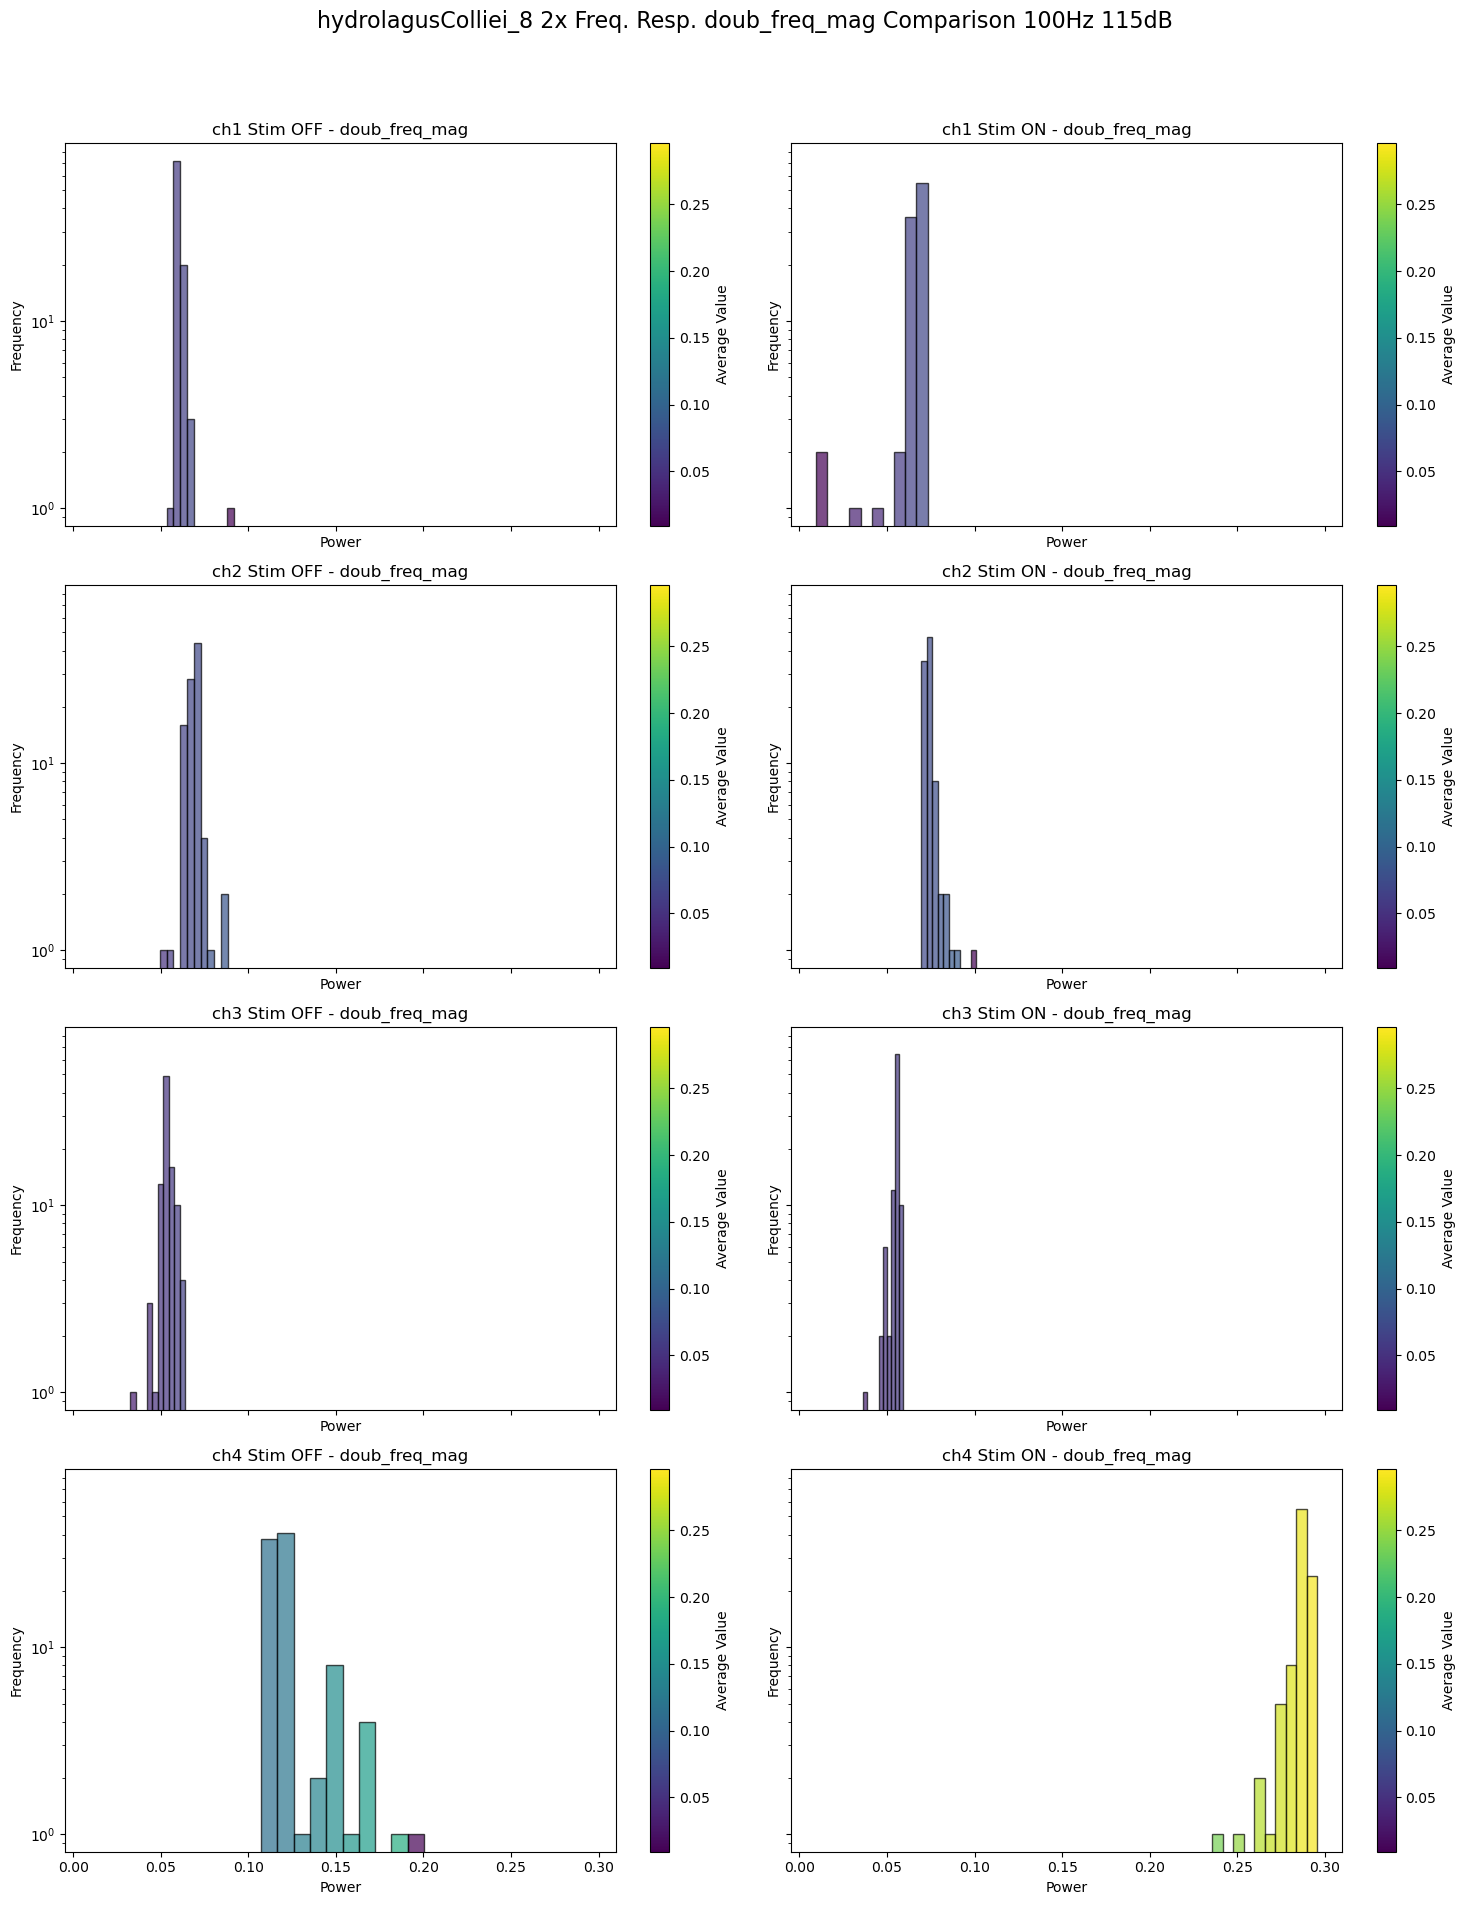

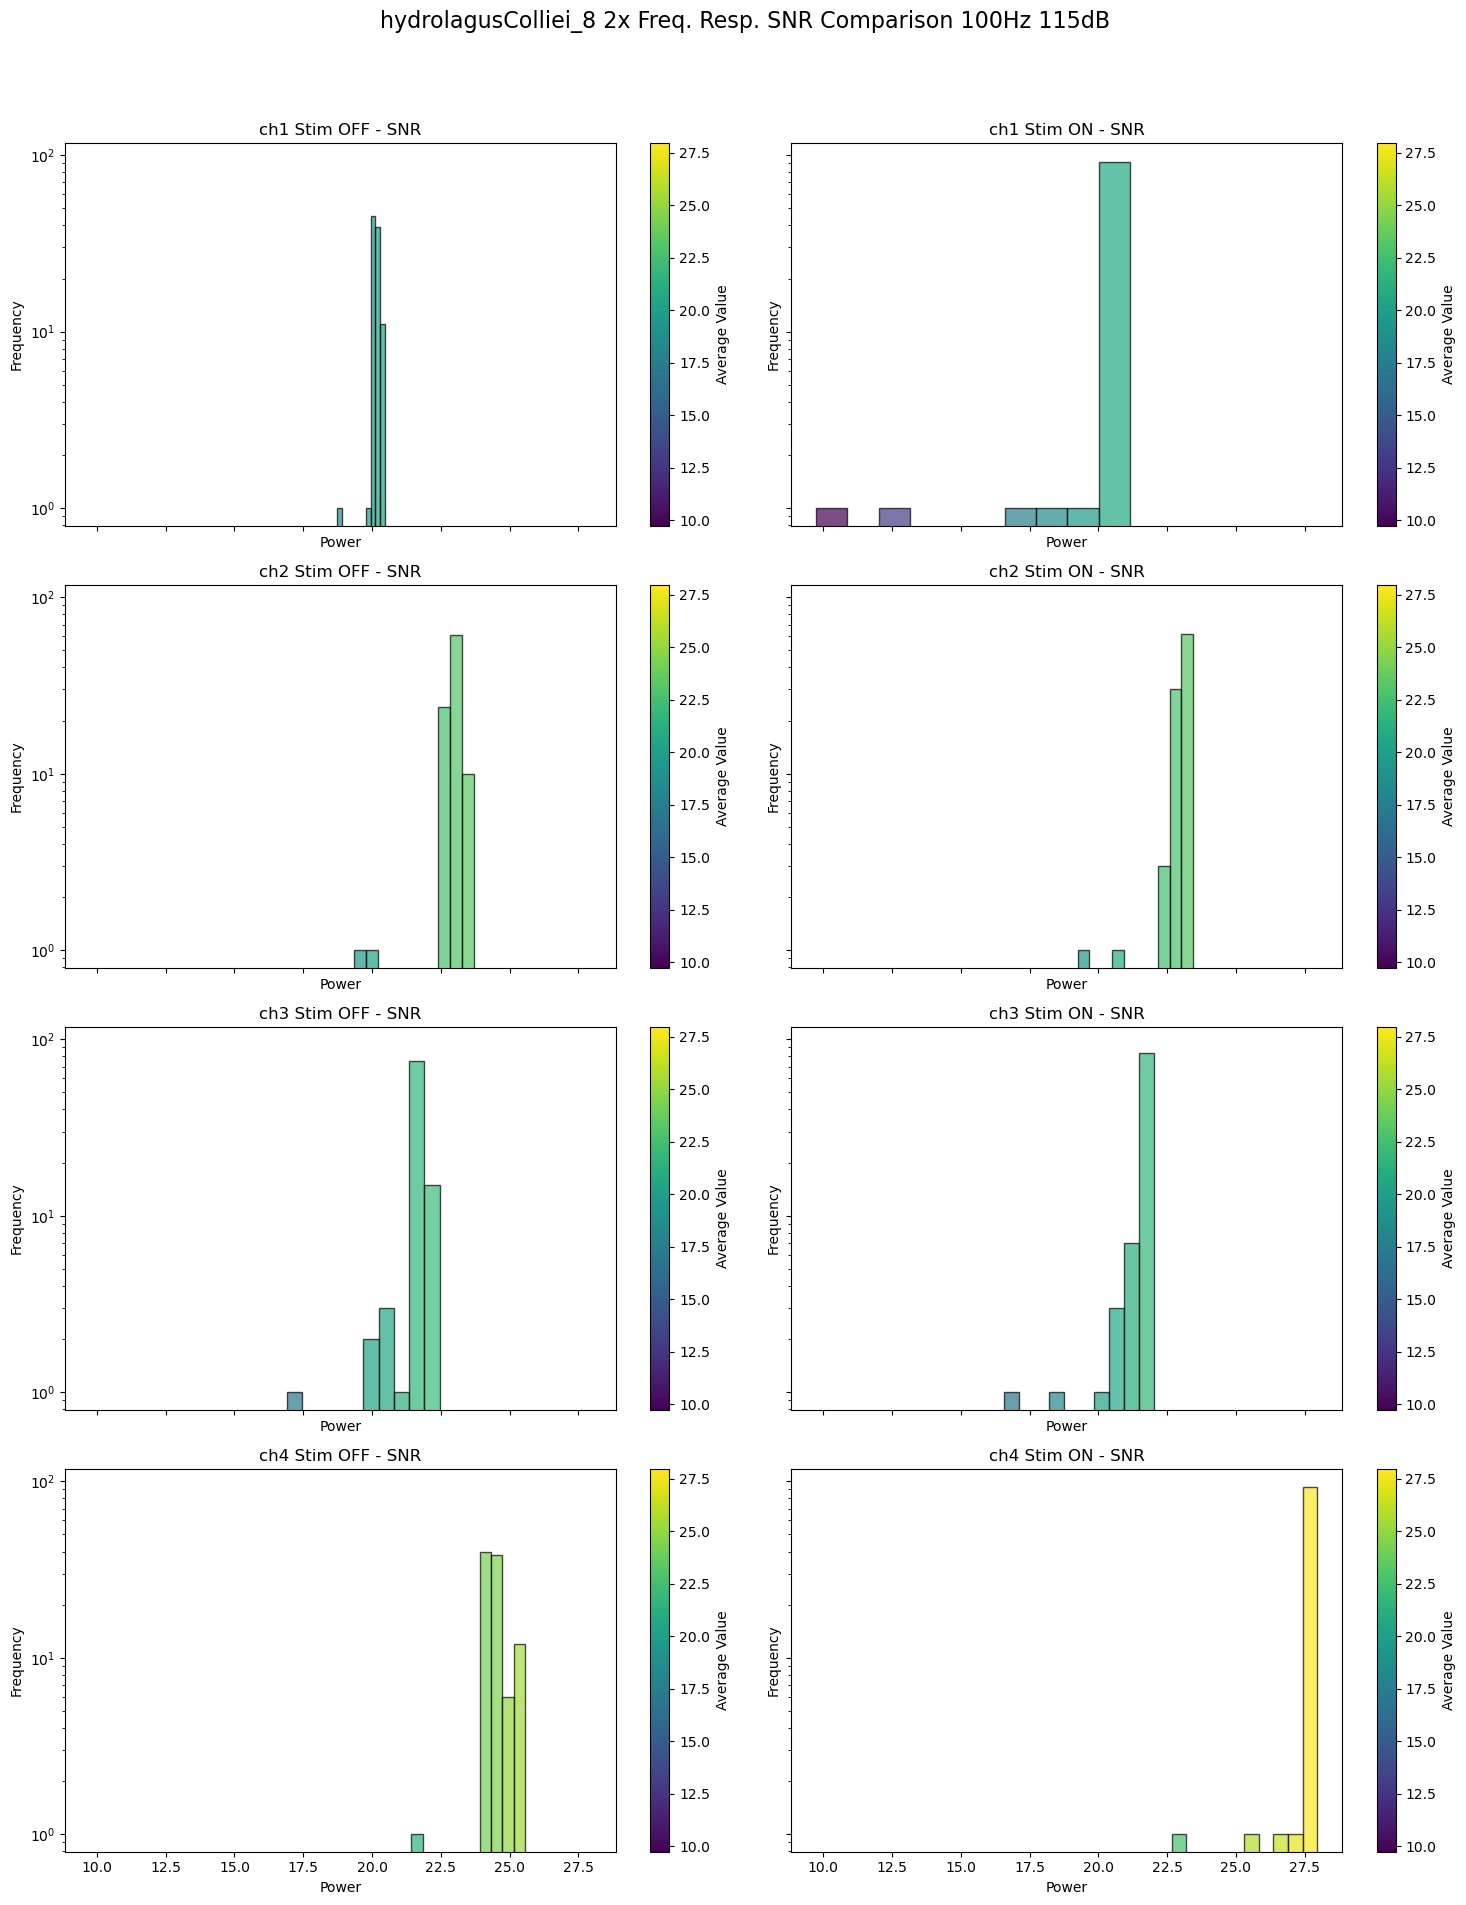

In [264]:
plot_collapsed_color_hist(doub_freq_data, subjid, channel_keys, submetric_keys, myfreq, myamp, 10)

### Scatter plot with std info included

In [265]:
def plot_mean_std_scatter(data, subjid, myfreq, myamp, metric_1, metric_2):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

    # First subplot
    ax1.grid(alpha=0.3)
    ax1.scatter(data['prestim'][metric_1], data['prestim'][metric_2], alpha=0.7)
    ax1.set_title('Subplot 1')
    ax1.set_xlabel('Mean')
    ax1.set_ylabel('STD')

    # Second subplot
    ax2.grid(alpha=0.3)
    ax2.scatter(data['stimresp'][metric_1], data['stimresp'][metric_2], color='orange', alpha=0.7)
    ax2.set_title('Subplot 2')
    ax2.set_xlabel('Mean')
    ax2.set_ylabel('STD')

    # Add an overall title
    fig.suptitle(f'{subjid} {myfreq} Hz {myamp} dB: 2x Freq. Resp Mean vs. STD Across Cumulative Averages')

    # Adjust layout and show
    plt.tight_layout()
    plt.savefig(f"{subjid}_2x_resp_scatter_{myfreq}Hz_{myamp}dB.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=300)
    plt.show()


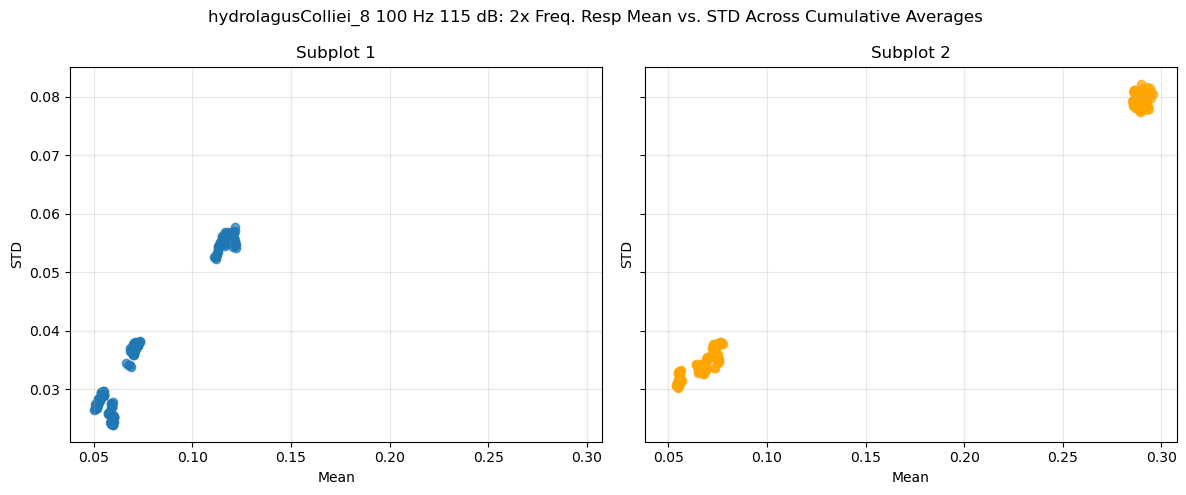

In [266]:
plot_mean_std_scatter(collapsed_data, subjid, myfreq, myamp, 'doub_freq_mag', 'doub_freq_mag_std')

### Box and whisker plots

In [267]:
def plot_box_whisker(data, subjid, myfreq, myamp, metric):
    # Create the figure with one row, two columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Boxplot for pre-stimulus
    ax1.boxplot(data['prestim'][metric], vert=True, patch_artist=True)
    ax1.set_title('Stim OFF')
    ax1.set_ylabel('Power')
    ax1.set_xticks([1])
    ax1.set_xticklabels(['Pre-Stim'])

    # Boxplot for stimulus response
    ax2.boxplot(data['stimresp'][metric], vert=True, patch_artist=True)
    ax2.set_title('Stim ON')
    ax2.set_xticks([1])
    ax2.set_xticklabels(['Stim Resp'])

    # Add an overall title
    fig.suptitle(f'{subjid} {metric} {myfreq} Hz {myamp} dB: Double freq. resp. magnitudes')

    # Adjust layout and show
    plt.tight_layout()
    plt.savefig(f"{subjid}_{metric}_2x_resp_box_{myfreq}Hz_{myamp}dB.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=300)
    plt.show()


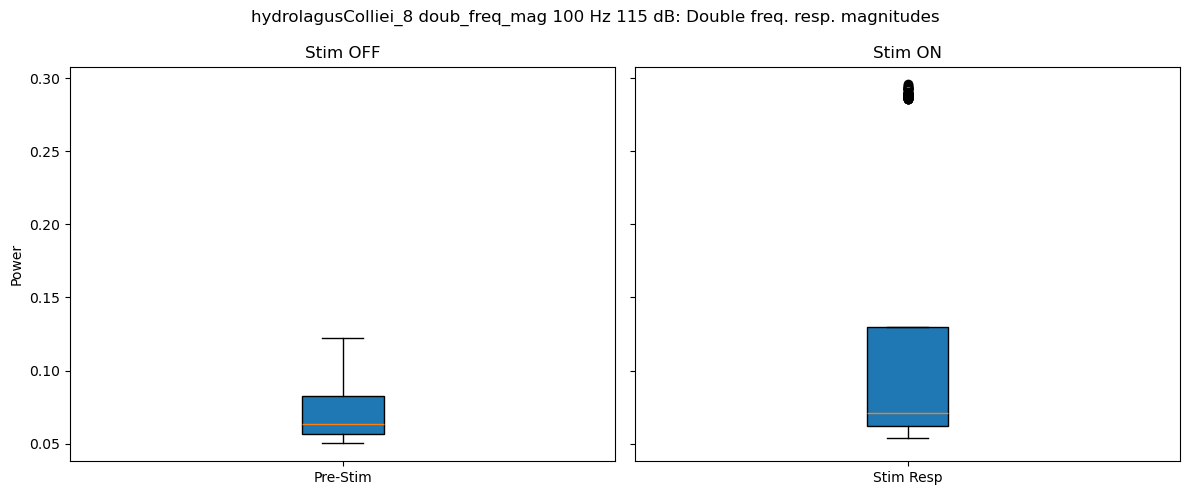

In [268]:
plot_box_whisker(collapsed_data, subjid, myfreq, myamp, 'doub_freq_mag')

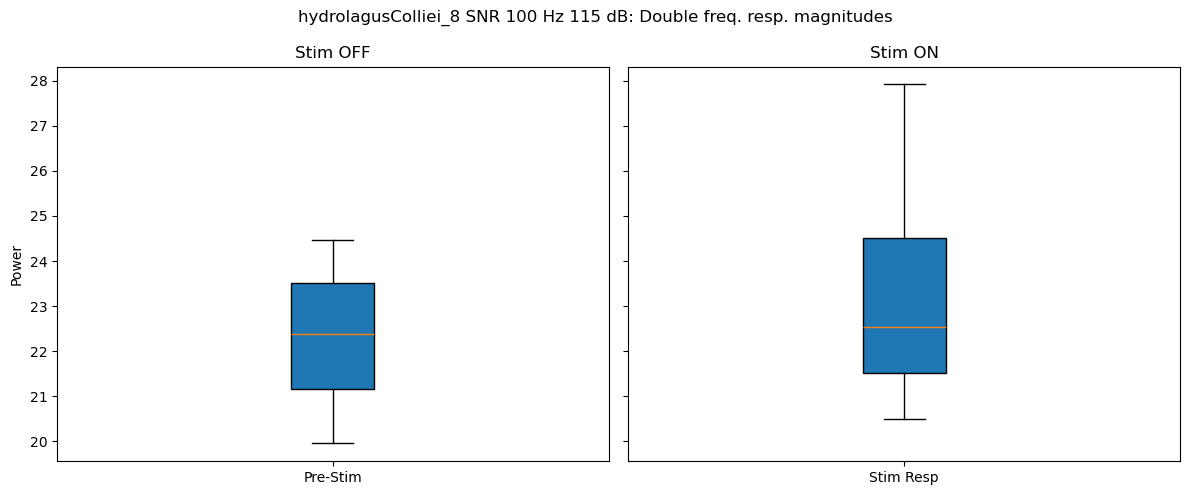

In [269]:
plot_box_whisker(collapsed_data, subjid, myfreq, myamp, 'SNR')

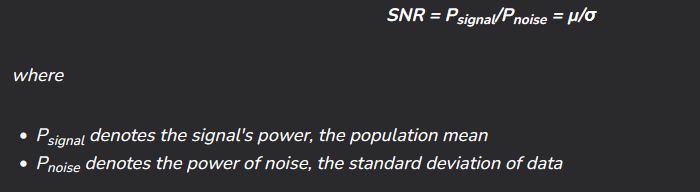

## STOP!

### T-test based hmmm not normal!

In [270]:
from scipy import stats

### Valid to use t-tests on non normal data?? Hmm my data is super not normal so maybe not
t_stats = {channel: [] for channel in channel_keys}
p_vals = {channel: [] for channel in channel_keys}

for channel in channel_keys:
    for my_cum in range(len(stim_resp_doub_power[channel])):

        mean1 = stim_resp_doub_power[channel][my_cum]
        mean2 = pre_stim_doub_power[channel][my_cum]

        std1 = stim_resp_doub_power_std[channel][my_cum]
        std2 = pre_stim_doub_power_std[channel][my_cum]
        
        nobs1 = stimresp_cumulative_trials[channel][my_cum]
        nobs2 = prestim_cumulative_trials[channel][my_cum]

        # Perform the t-test
        t_statistic, p_value = stats.ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                                                        mean2=mean2, std2=std2, nobs2=nobs2)
        
        t_stats[channel].append(t_statistic)
        p_vals[channel].append(p_value)

NameError: name 'stim_resp_doub_power' is not defined

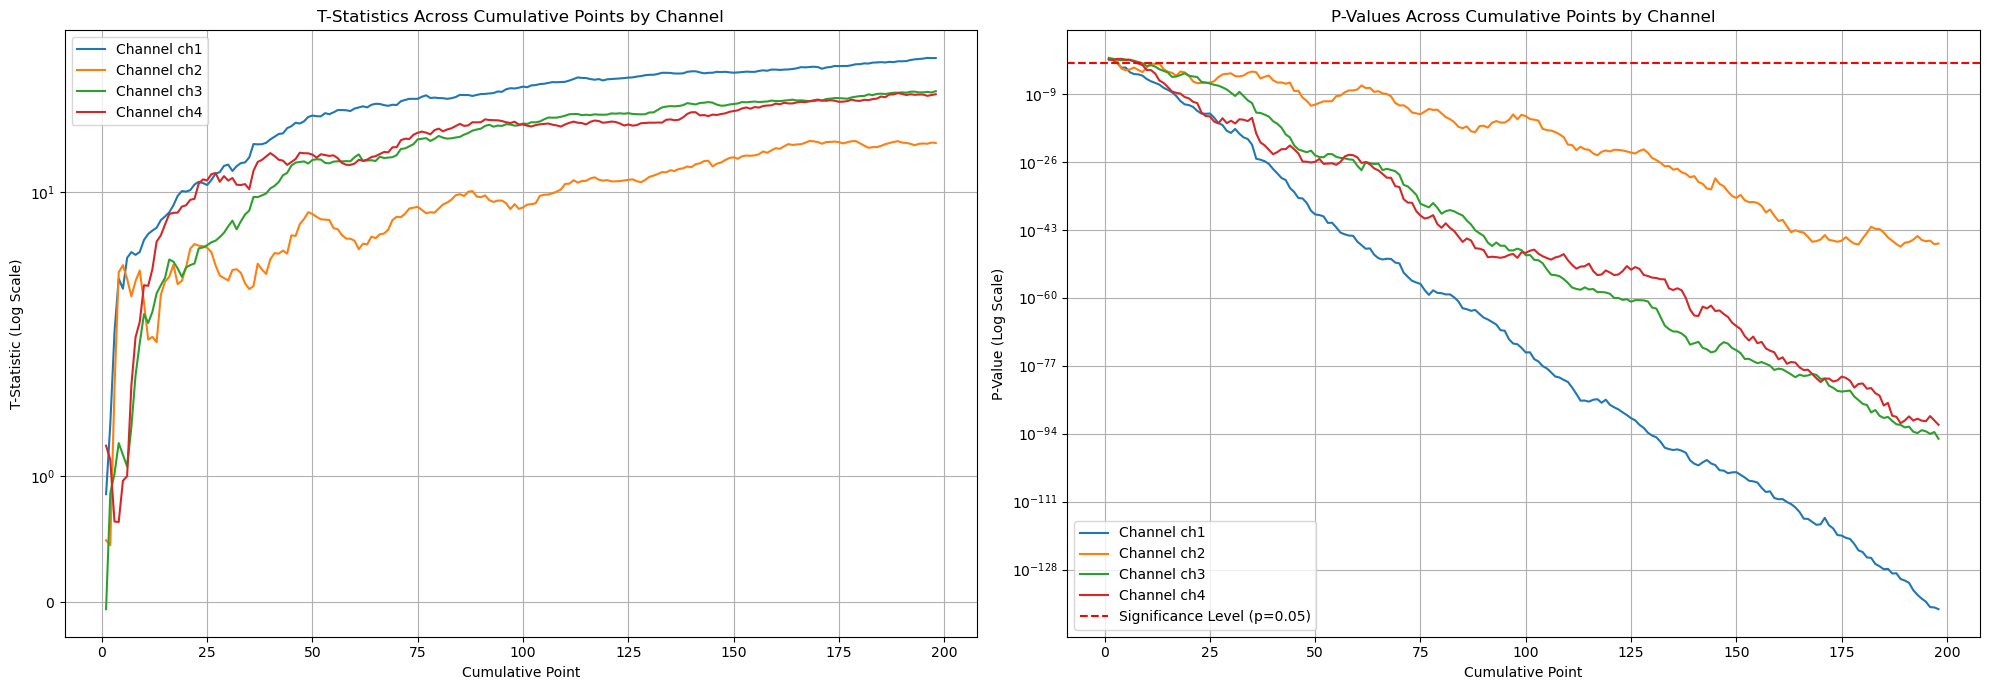

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with side-by-side subplots
plt.figure(figsize=(20, 7))

# Subplot for t-statistics (log scale)
plt.subplot(1, 2, 1)
plt.title('T-Statistics Across Cumulative Points by Channel')
plt.xlabel('Cumulative Point')
plt.ylabel('T-Statistic (Log Scale)')
plt.yscale('symlog')  # Symmetric log scale to handle negative and positive values
for channel in channel_keys:
    plt.plot(t_stats[channel], label=f'Channel {channel}')
plt.legend()
plt.grid(True)

# Subplot for p-values (log scale)
plt.subplot(1, 2, 2)
plt.title('P-Values Across Cumulative Points by Channel')
plt.xlabel('Cumulative Point')
plt.ylabel('P-Value (Log Scale)')
plt.yscale('log')
for channel in channel_keys:
    plt.plot(p_vals[channel], label=f'Channel {channel}')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (p=0.05)')
plt.legend()
plt.grid(True)

fig.suptitle(f"T-Test Results: {myfreq}Hz {myamp}dB")

plt.tight_layout()
plt.savefig(f"{subjid}_t_test_lineplot_{myfreq}Hz_{myamp}dB.png", 
            format='png', 
            bbox_inches='tight', 
            dpi=300)
plt.show()

### Learnings about t-test and normality


### Check for normality

In [ ]:
data = stimresp_cumulative[channel]  # shape (n_trials, n_timepoints)

# Collapse each trial to a single representative value (e.g., mean or RMS power)
trial_means = np.sqrt(np.mean(data**2, axis=1))  # one value per trial

# Check normality of those trial-level values
shapiro_result = stats.shapiro(trial_means)
dagostino_result = stats.normaltest(trial_means)

print("Shapiro-Wilk p =", shapiro_result.pvalue)
print("D’Agostino-Pearson p =", dagostino_result.pvalue)

Shapiro-Wilk p = 2.060683807549366e-24
D’Agostino-Pearson p = 3.992147929019535e-54


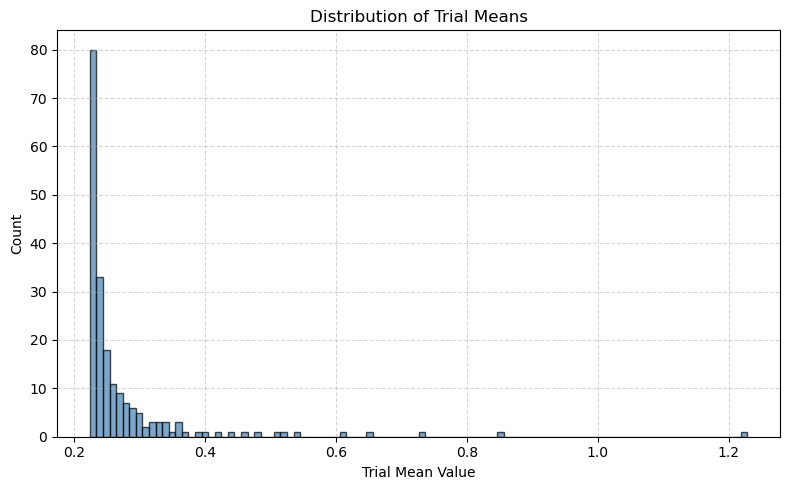

In [ ]:
# trial_means is a 1D NumPy array of your per-trial means or RMS values
# Example: trial_means = np.sqrt(np.mean(data**2, axis=1))

plt.figure(figsize=(8, 5))
plt.hist(trial_means, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Trial Means")
plt.xlabel("Trial Mean Value")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
